# Importaciones y funciones aux

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Análisis de los datos a nivel básico

Primero, es necesario ver si las clases están balanceadas, ya que un desbalance provoca que el modelo prediga mejor las clases mayoritarias, frente a las clases minoritarias.

In [ ]:
def count_images_dir(path, extensions=("jpg", "png", "jpeg", "gif", "bmp", "tiff")):
    count = {}
    for dir, _, files in os.walk(path):
        num_imgs = sum(1 for archivo in files if archivo.lower().endswith(extensions))
        if dir != path:
            dirname = os.path.basename(dir)
            count[dirname] = num_imgs
    return count

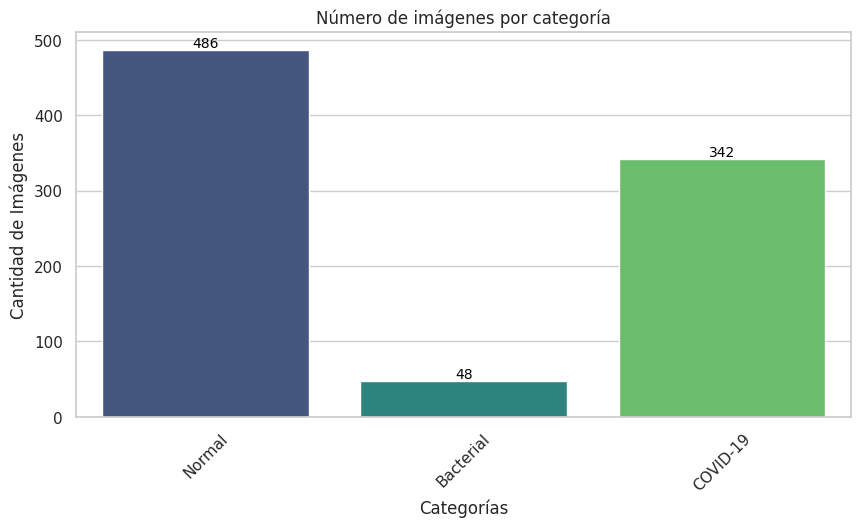

,Categoría,Instancias,Porcentaje
0,Normal,486,55.479452
1,Bacterial,48,5.479452
2,COVID-19,342,39.041096


In [ ]:
path = "./data/covid-chest-xray"
count_imgs = count_images_dir(path)

# Dataframe para el balanceo de clases
df = pd.DataFrame(list(count_imgs.items()), columns=["Categoría", "Instancias"])
df["Porcentaje (%)"] = (df["Instancias"] / df["Instancias"].sum()) * 100

# Gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df, x="Categoría", y="Instancias", hue="Categoría", legend=False, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Categorías")
plt.ylabel("Cantidad de Imágenes")
plt.title("Número de imágenes por categoría")

# Mostrar valores en las barras
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=10, color="black")
plt.show()

df

Se observa un claro desbalanceo. Para el primer problema binario (sano y enfermo) no debería haber ningún problema, aunque sería conveniente subir un poco la muestra de neumonía. En cambio, el segundo problema (sano, neumonía y covid), neumonía es una clase minoritaria, dificultando la tarea de predecir en caso de neumonía. Es por ello, se realizará un data augmentation para poder equilibrar este desbalance.

# Data Augmentation

Para el data augmentation, se realizan diferentes filtros:
  - **`rotation_range`**: Rotación aleatoria en grados.
  - **`width_shift_range`**: Desplazamiento horizontal aleatorio.
  - **`height_shift_range`**: Desplazamiento vertical aleatorio.
  - **`zoom_range`**: Zoom aleatorio en el rango indicado.
  - **`brightness_range`**: Ajuste de brillo aleatorio entre los valores indicados.
  - **`horizontal_flip`**: Voltea horizontalmente las imágenes de forma aleatoria.
  - **`fill_mode='nearest'`**: Rellena píxeles vacíos tras la transformación con valores cercanos.

In [ ]:
def create_data_generator(is_not_balanced=False):
    # En caso de no estar balanceado, es más agresivo el ruido aplicado
    if is_not_balanced:
        return ImageDataGenerator(
            rotation_range=25,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.3,
            brightness_range=[0.7, 1.3],
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:
        return ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.2,
            brightness_range=[0.8, 1.2],
            horizontal_flip=True,
            fill_mode='nearest'
        )

Se realiza cada uno de los filtros de forma individual para una imagen de cada clase. A partir de aquí, se ve la utilidad de cada uno de ellos, como del efecto directo en las imágenes.

In [ ]:
def show_filter_effect(generator, class_images, filter_name):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    fig.suptitle(f"Filtro aplicado: {filter_name}", fontsize=14)

    for i, (class_name, img_path) in enumerate(class_images.items()):
        image = load_img(img_path, target_size=(224, 224), color_mode='grayscale')
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)

        # Aplicar el filtro
        augmented_image = generator.flow(image_array, batch_size=1)[0]

        # Mostrar la imagen
        axes[i].imshow(augmented_image.squeeze(), cmap='gray')
        axes[i].set_title(class_name)
        axes[i].axis('off')

    plt.show()

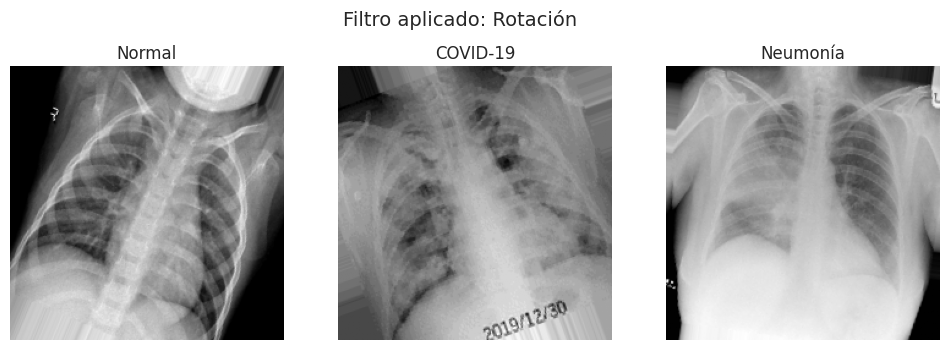

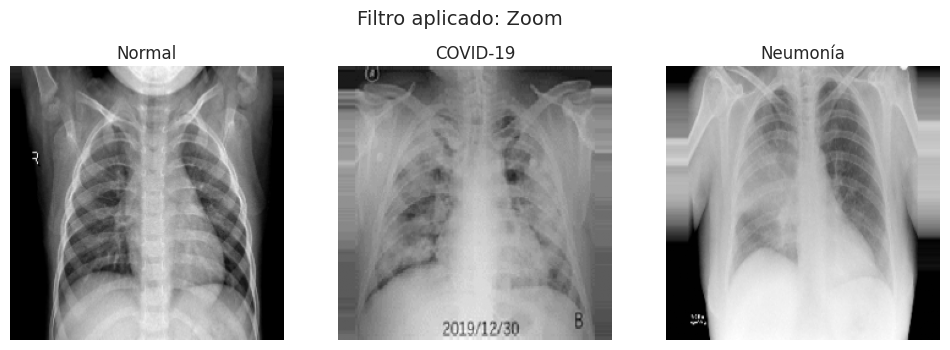

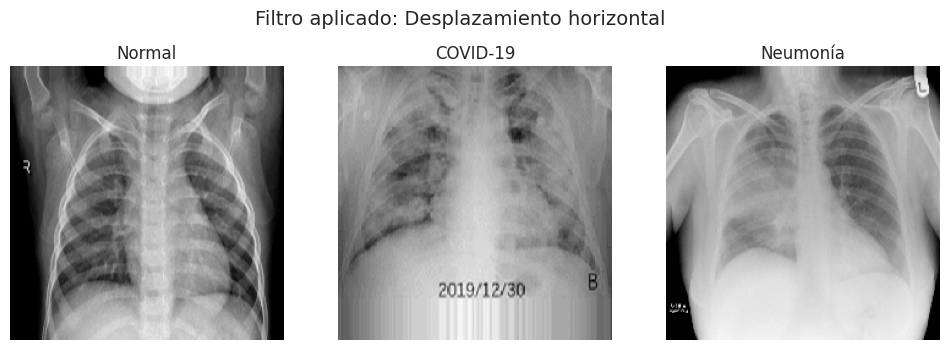

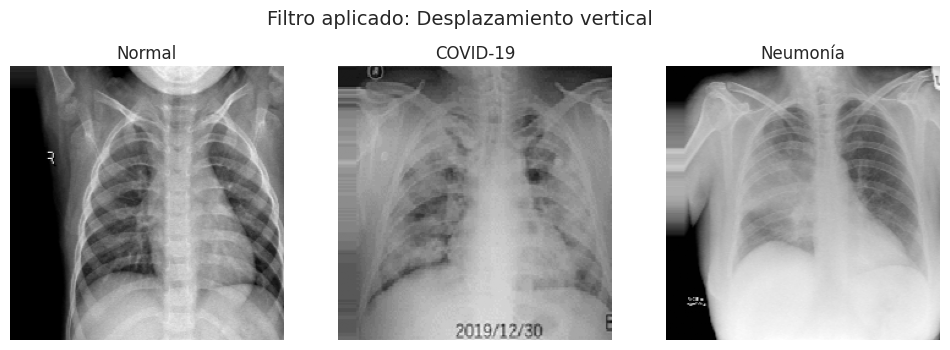

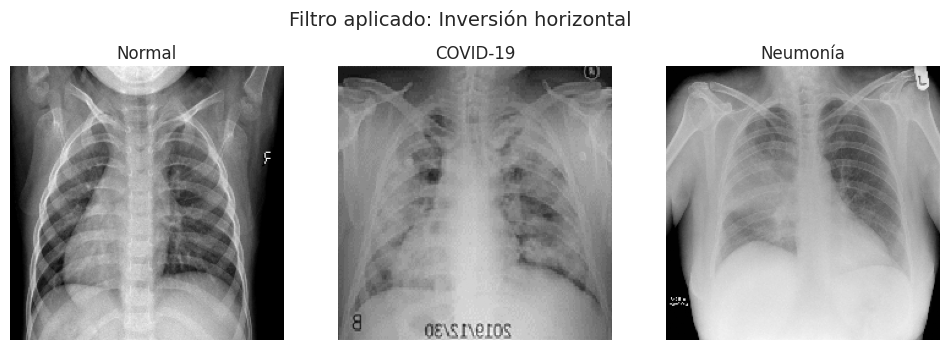

In [ ]:
augment_generator = create_data_generator()

# Rutas de imágenes de ejemplo (asegúrate de cambiar estos paths a imágenes existentes en tu dataset)
example_images = {
    'Normal': '/content/drive/MyDrive/covid-chest-xray/Normal/NORMAL2-IM-1349-0001.jpeg',
    'COVID-19': '/content/drive/MyDrive/covid-chest-xray/COVID-19/ryct.2020003.fig2-b.png',
    'Neumonía': '/content/drive/MyDrive/covid-chest-xray/Bacterial/pneumococcal-pneumonia-day0.jpg'
}

# Aplicar diferentes filtros y mostrar resultados
filter_generators = {
    "Rotación": ImageDataGenerator(rotation_range=30),
    "Zoom": ImageDataGenerator(zoom_range=0.2),
    "Desplazamiento horizontal": ImageDataGenerator(width_shift_range=0.2),
    "Desplazamiento vertical": ImageDataGenerator(height_shift_range=0.2),
    "Inversión horizontal": ImageDataGenerator(horizontal_flip=True)
}

for filter_name, generator in filter_generators.items():
    show_filter_effect(generator, example_images, filter_name)

# Creación del dataset con Data Augmentation

Para este dataset nuevo, se generarán 500 imágenes de las clases mayoritarias (sano y COVID-19) y 1000 imágenes de las clases minoritarias (neumonía). A partir de aquí se mezclarán en la siguiente etapa, a la hora de realizar los conjuntos de entrenamiento y test, al igual que el conjunto de validación.

In [ ]:
data_dir = './data/covid-chest-xray/'
output_dir = './data/data_augmentation'
classes = ['Normal', 'COVID-19', 'Bacterial']

for cls in classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

batch_size = 32
img_size = (224, 224)

# Generadores de imágenes
augment_generators = {
    'Normal': create_data_generator(),
    'COVID-19': create_data_generator(),
    'Bacterial': create_data_generator(is_not_balanced=True)
}

# Número de imágenes a generar
num_images_to_generate = {'Normal': 500, 'COVID-19': 500, 'Bacterial': 1000}
counters = {'Normal': 0, 'COVID-19': 0, 'Bacterial': 0}

# Generación de imágenes balanceadas
for cls in classes:
    class_dir = os.path.join(data_dir, cls)

    # Cargar imágenes originales
    generator = augment_generators[cls].flow_from_directory(
        data_dir,
        classes=[cls],
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True
    )

    # Generar imágenes hasta alcanzar el límite deseado
    while counters[cls] < num_images_to_generate[cls]:
        x_batch = next(generator)  # Obtiene un lote de imágenes

        for i, img in enumerate(x_batch):
            if counters[cls] < num_images_to_generate[cls]:
                img_pil = array_to_img(img)
                img_pil.save(os.path.join(output_dir, cls, f'augmented_{counters[cls]}.jpg'))
                counters[cls] += 1
            else:
                break

Found 486 images belonging to 1 classes.
Found 342 images belonging to 1 classes.
Found 48 images belonging to 1 classes.
